In [194]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc, \
    classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_wine
import optuna

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
X, Y = load_wine(return_X_y=True)
X.shape, Y.shape

((178, 13), (178,))

(array([59.,  0.,  0.,  0.,  0., 71.,  0.,  0.,  0., 48.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

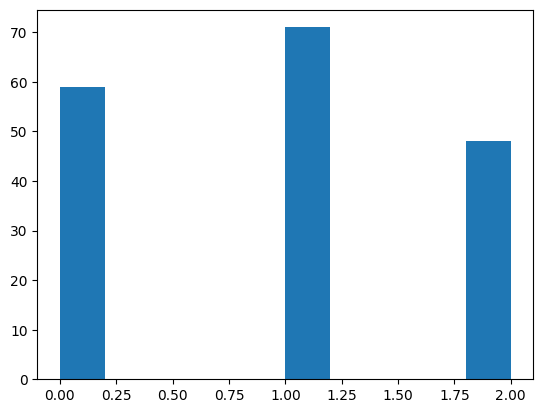

In [3]:
plt.hist(Y)

In [22]:
class_counts = [np.sum(Y == k) for k in [0, 1, 2]]
class_ratios = [cc / sum(class_counts) for cc in class_counts]

class_counts, class_ratios

([59, 71, 48], [0.33146067415730335, 0.398876404494382, 0.2696629213483146])

In [10]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train, test = next(sss.split(X, Y))
Xtr, Xte = X[train], X[test]
Ytr, Yte = Y[train], Y[test]
train.shape, test.shape

((124,), (54,))

lr_accuracy=0.98


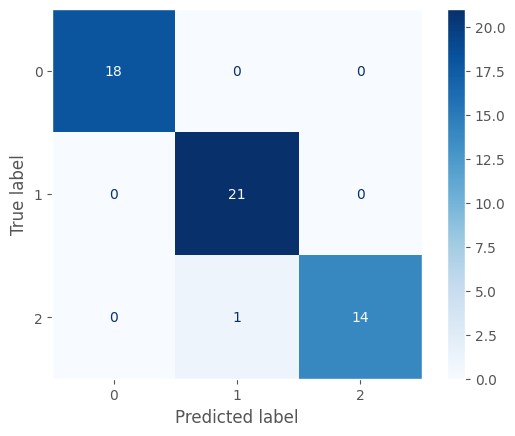

In [170]:
lr_model = LogisticRegression()
# sample_weights = np.array([1 / class_ratios[k] for k in Ytr])
lr_model.fit(Xtr, Ytr)

pred = lr_model.predict(Xte)
lr_accuracy = accuracy_score(Yte, pred)
print(f"{lr_accuracy=:.2f}")

cm = confusion_matrix(Yte, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.grid(False)

knn_accuracy=0.72


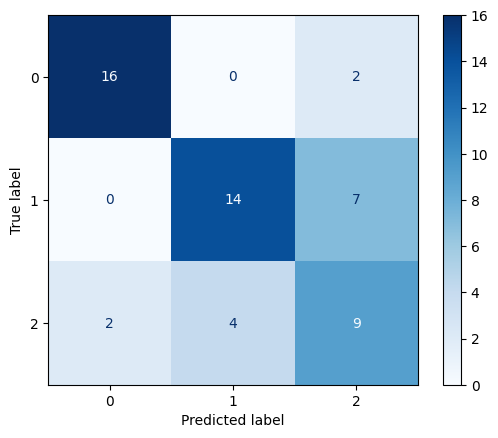

In [12]:
knn = KNeighborsClassifier()
knn.fit(Xtr, Ytr)

pred = knn.predict(Xte)
knn_accuracy = accuracy_score(Yte, pred)
print(f"{knn_accuracy=:.2f}")

cm = confusion_matrix(Yte, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

lda_accuracy=0.98


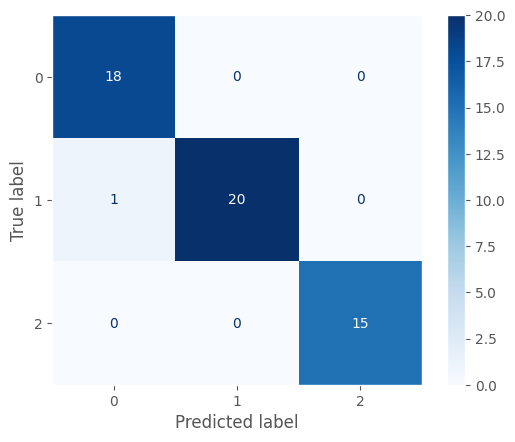

In [74]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(Xtr, Ytr)

pred = lda_model.predict(Xte)
lda_accuracy = accuracy_score(Yte, pred)
print(f"{lda_accuracy=:.2f}")

cm = confusion_matrix(Yte, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.grid(False)

# Optuna optimisation

In [ ]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#
# for i, (train, test) in enumerate(skf.split(X, Y)):
#     print(f"Fold {i}:")
#     X_train, X_test = X[train], X[test]
#     y_train, y_test = Y[train], Y[test]

In [120]:
def objective_lr(trial):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    solver = trial.suggest_categorical("solver", ['lbfgs', 'liblinear', 'saga'])
    max_iter = trial.suggest_int("max_iter", 100, 1000)

    lr_model = LogisticRegression(C=C, solver=solver, max_iter=max_iter, random_state=42)

    score = cross_val_score(lr_model, Xtr, Ytr, cv=5, scoring='accuracy').mean()
    # pred = lr_model.predict(Xte)
    # score = accuracy_score(Yte, pred)
    return score

In [121]:
lr_study = optuna.create_study(study_name='wine', direction='maximize', sampler=optuna.samplers.RandomSampler(42))
lr_study.optimize(objective_lr, n_trials=100)

[I 2025-11-02 17:08:35,292] A new study created in memory with name: wine
[I 2025-11-02 17:08:35,415] Trial 0 finished with value: 0.9436666666666665 and parameters: {'C': 0.0745934328572655, 'solver': 'lbfgs', 'max_iter': 240}. Best is trial 0 with value: 0.9436666666666665.
[I 2025-11-02 17:08:35,427] Trial 1 finished with value: 0.8383333333333333 and parameters: {'C': 0.0060252157362038605, 'solver': 'liblinear', 'max_iter': 737}. Best is trial 0 with value: 0.9436666666666665.
[I 2025-11-02 17:08:35,561] Trial 2 finished with value: 0.7906666666666667 and parameters: {'C': 0.001267425589893723, 'solver': 'lbfgs', 'max_iter': 263}. Best is trial 0 with value: 0.9436666666666665.
[I 2025-11-02 17:08:35,572] Trial 3 finished with value: 0.8713333333333333 and parameters: {'C': 0.008260808399079604, 'solver': 'liblinear', 'max_iter': 362}. Best is trial 0 with value: 0.9436666666666665.
[I 2025-11-02 17:08:35,654] Trial 4 finished with value: 0.7343333333333334 and parameters: {'C': 1

In [122]:
lr_study.best_params

{'C': 20.67840939783948, 'solver': 'lbfgs', 'max_iter': 380}

<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

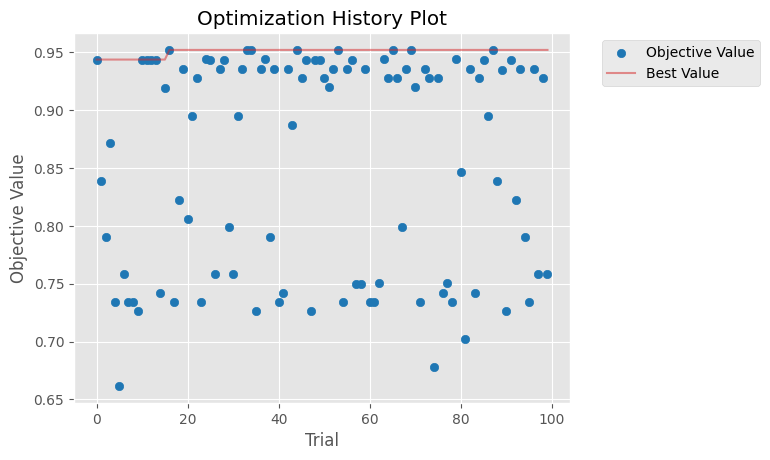

In [123]:
optuna.visualization.matplotlib.plot_optimization_history(lr_study)

lr_train_accuracy=0.99
lr_accuracy=0.98
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       0.91      0.95      0.93        21
           2       1.00      0.87      0.93        15

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.95      0.94      0.94        54



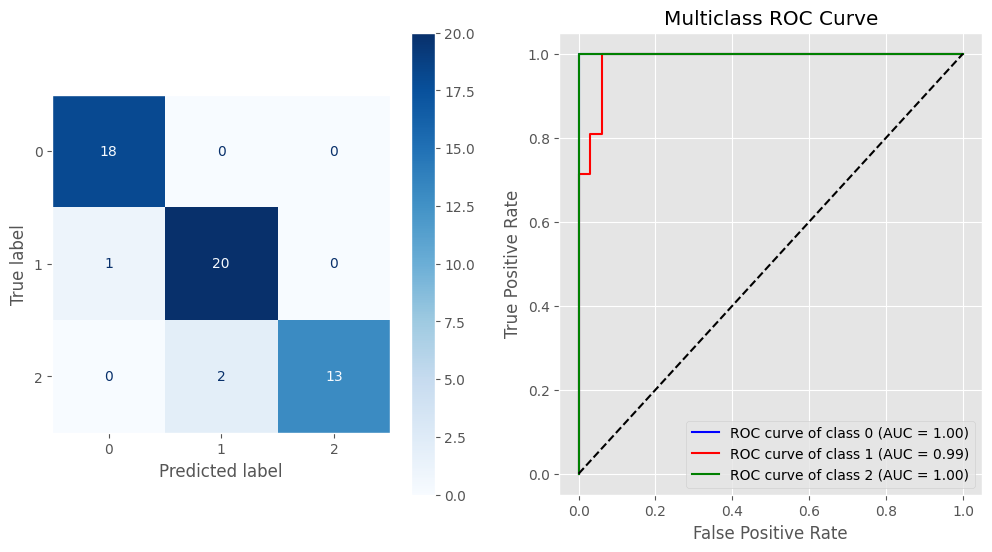

In [199]:
optimized_lr_model = LogisticRegression(C=lr_study.best_params["C"], solver=lr_study.best_params["solver"], max_iter=lr_study.best_params["max_iter"], random_state=42)
optimized_lr_model.fit(Xtr, Ytr)

train_pred = optimized_lr_model.predict(Xtr)
lr_train_accuracy = accuracy_score(Ytr, train_pred)
print(f"{lr_train_accuracy=:.2f}")

pred = optimized_lr_model.predict(Xte)
optimized_lr_accuracy = accuracy_score(Yte, pred)
print(f"{lr_accuracy=:.2f}")

print(classification_report(Yte, pred))

axs = plt.subplots(1, 2, figsize=(12, 6))[1].flatten()

cm = confusion_matrix(Yte, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", ax=axs[0])
plt.grid(False)
axs[0].grid(False)

probs = optimized_lr_model.predict_proba(Xte)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    y = np.zeros_like(Yte)
    y[Yte == i] = 1
    fpr[i], tpr[i], _ = roc_curve(y, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

ax = axs[1]
colors = np.array(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    label = f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})'
    plt.plot(fpr[i], tpr[i], color=color, label=label)

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Multiclass ROC Curve')
ax.legend(loc='lower right')
ax.grid(True)


In [127]:
def objective_knn(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 1, 15)
    weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan'])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)

    score = cross_val_score(model, Xtr, Ytr, cv=5, scoring='accuracy').mean()
    return score

In [129]:
knn_study = optuna.create_study(study_name='wine', direction='maximize', sampler=optuna.samplers.RandomSampler(42))
knn_study.optimize(objective_knn, n_trials=300)

[I 2025-11-02 17:10:12,011] A new study created in memory with name: wine
[I 2025-11-02 17:10:12,030] Trial 0 finished with value: 0.6786666666666668 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.6786666666666668.
[I 2025-11-02 17:10:12,039] Trial 1 finished with value: 0.807 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.807.
[I 2025-11-02 17:10:12,054] Trial 2 finished with value: 0.718 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 1 with value: 0.807.
[I 2025-11-02 17:10:12,065] Trial 3 finished with value: 0.7583333333333333 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.807.
[I 2025-11-02 17:10:12,074] Trial 4 finished with value: 0.7583333333333333 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is tr

knn_study.best_params={'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

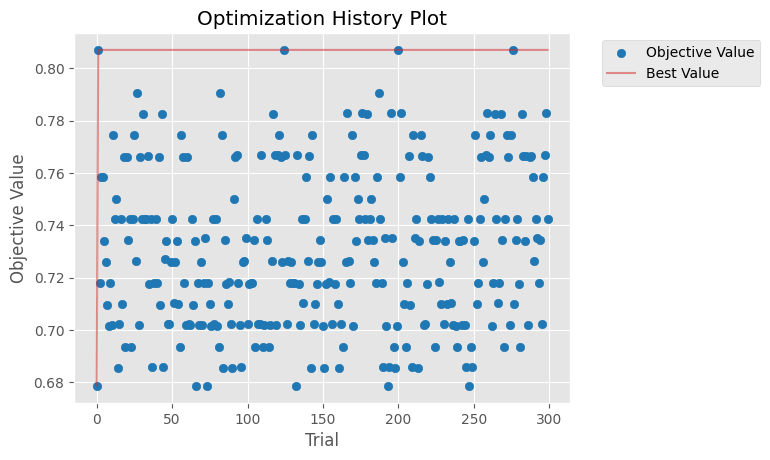

In [131]:
print(f"{knn_study.best_params=}")
optuna.visualization.matplotlib.plot_optimization_history(knn_study)

optimized_knn_accuracy=0.76
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       0.73      0.76      0.74        21
           2       0.57      0.53      0.55        15

    accuracy                           0.76        54
   macro avg       0.75      0.75      0.75        54
weighted avg       0.76      0.76      0.76        54



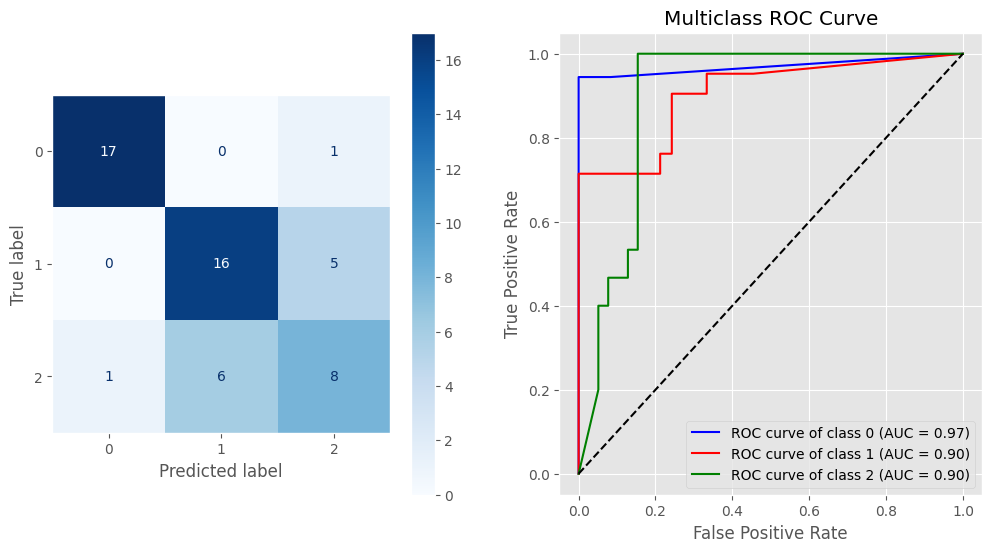

In [198]:
optimized_knn_model = KNeighborsClassifier(n_neighbors=knn_study.best_params["n_neighbors"], weights=knn_study.best_params["weights"], metric=knn_study.best_params["metric"])
optimized_knn_model.fit(Xtr, Ytr)

pred = optimized_knn_model.predict(Xte)
optimized_knn_accuracy = accuracy_score(Yte, pred)
print(f"{optimized_knn_accuracy=:.2f}")

print(classification_report(Yte, pred))

axs = plt.subplots(1, 2, figsize=(12, 6))[1].flatten()

cm = confusion_matrix(Yte, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", ax=axs[0])
plt.grid(False)
axs[0].grid(False)

probs = optimized_knn_model.predict_proba(Xte)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    y = np.zeros_like(Yte)
    y[Yte == i] = 1
    fpr[i], tpr[i], _ = roc_curve(y, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

ax = axs[1]
colors = np.array(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    label = f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})'
    plt.plot(fpr[i], tpr[i], color=color, label=label)

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Multiclass ROC Curve')
ax.legend(loc='lower right')
ax.grid(True)

In [162]:
def objective_lda(trial):
    solver = trial.suggest_categorical("solver", ['lsqr', 'eigen', 'svd'])

    if solver in ['lsqr', 'eigen']:
        shrinkage = trial.suggest_float("shrinkage", 1e-3, 1, log=True)
    else:
        shrinkage = None

    model = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage)

    score = cross_val_score(model, Xtr, Ytr, cv=5, scoring='accuracy').mean()
    return score

In [163]:
lda_study = optuna.create_study(study_name='wine', direction='maximize', sampler=optuna.samplers.RandomSampler(42))
lda_study.optimize(objective_lda, n_trials=300)

[I 2025-11-02 17:23:44,330] A new study created in memory with name: wine
[I 2025-11-02 17:23:44,358] Trial 0 finished with value: 0.702 and parameters: {'solver': 'eigen', 'shrinkage': 0.06251373574521749}. Best is trial 0 with value: 0.702.
[I 2025-11-02 17:23:44,372] Trial 1 finished with value: 0.7023333333333333 and parameters: {'solver': 'lsqr', 'shrinkage': 0.39676050770529875}. Best is trial 1 with value: 0.7023333333333333.
[I 2025-11-02 17:23:44,387] Trial 2 finished with value: 0.7103333333333334 and parameters: {'solver': 'eigen', 'shrinkage': 0.8123245085588685}. Best is trial 2 with value: 0.7103333333333334.
[I 2025-11-02 17:23:44,401] Trial 3 finished with value: 0.8789999999999999 and parameters: {'solver': 'lsqr', 'shrinkage': 0.0035498788321965025}. Best is trial 3 with value: 0.8789999999999999.
[I 2025-11-02 17:23:44,416] Trial 4 finished with value: 0.8303333333333335 and parameters: {'solver': 'eigen', 'shrinkage': 0.007476312062252299}. Best is trial 3 with valu

lda_study.best_params={'solver': 'lsqr', 'shrinkage': 0.0011919481947918731}


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

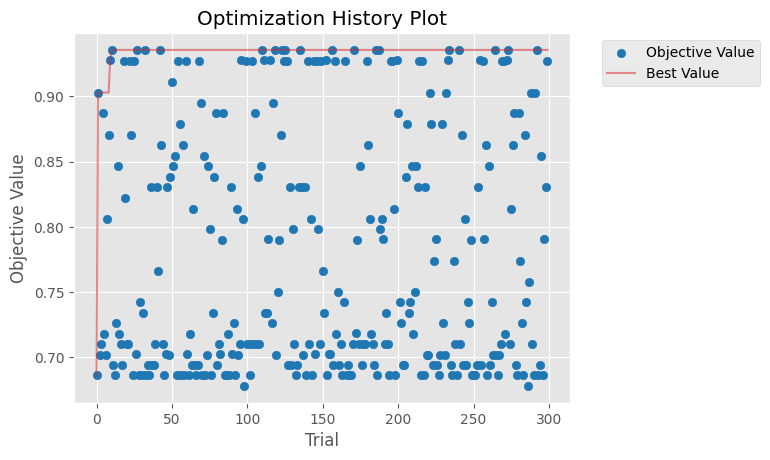

In [161]:
print(f"{lda_study.best_params=}")
optuna.visualization.matplotlib.plot_optimization_history(lda_study)

optimized_lda_accuracy=0.98
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.95      0.98        21
           2       1.00      1.00      1.00        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



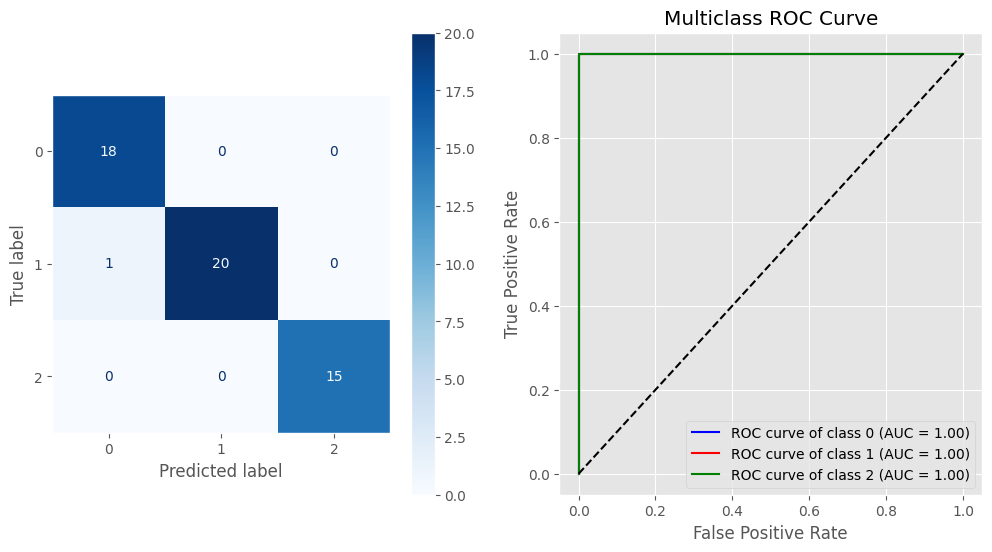

In [197]:
optimized_lda_model = LinearDiscriminantAnalysis(solver=lda_study.best_params['solver'], shrinkage=lda_study.best_params.get('shrinkage'))
optimized_lda_model.fit(Xtr, Ytr)

pred = optimized_lda_model.predict(Xte)
optimized_lda_accuracy = accuracy_score(Yte, pred)
print(f"{optimized_lda_accuracy=:.2f}")

print(classification_report(Yte, pred))

axs = plt.subplots(1, 2, figsize=(12, 6))[1].flatten()

cm = confusion_matrix(Yte, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", ax=axs[0])
plt.grid(False)
axs[0].grid(False)

probs = optimized_lda_model.predict_proba(Xte)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    y = np.zeros_like(Yte)
    y[Yte == i] = 1
    fpr[i], tpr[i], _ = roc_curve(y, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

ax = axs[1]
colors = np.array(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    label = f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})'
    plt.plot(fpr[i], tpr[i], color=color, label=label)

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Multiclass ROC Curve')
ax.legend(loc='lower right')
ax.grid(True)

In [185]:
def plot_comparison(ax, data1, data2, title):
    assert len(data1) == len(data2) == 3

    labels = [
        "Logistic",
        "KNN",
        "LDA"
    ]

    width = 0.35
    x = np.arange(0, len(labels))

    bars1 = ax.bar(x - width / 2, accuracies, width, label="Default")
    bars2 = ax.bar(x + width / 2, hog_accuracies, width, label="optuna")

    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax.set_ylabel(title)
    ax.legend()
    ax.grid(False)

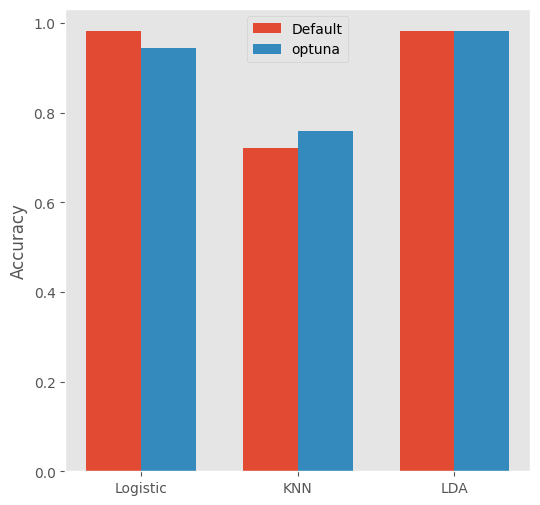

In [188]:
axs = plt.subplots(1, 1, figsize=(6, 6))[1]

accuracies = np.array([
    lr_accuracy,
    knn_accuracy,
    lda_accuracy,
])
opt_accuracies = np.array([
    optimized_lr_accuracy,
    optimized_knn_accuracy,
    optimized_lda_accuracy,
])

plot_comparison(axs, accuracies, opt_accuracies, "Accuracy")
